In [1]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt
import hierarchical as hrc
import warnings
warnings.filterwarnings('ignore')

import ontology_class

In [2]:
device = torch.device("cpu")
# tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
tokenizer = AutoTokenizer.from_pretrained(
    "EleutherAI/pythia-70M-deduped",
    revision="step13000",
    cache_dir=f"/mnt/bigstorage/raymond/huggingface_cache/pythia-70M-deduped/step13000"
)

g = torch.load('/mnt/bigstorage/raymond/70M-unembeddings/step13000').to(device) # 'FILE_PATH' in store_matrices.py

# g = torch.load('FILE_PATH').to(device)

vocab_dict = tokenizer.get_vocab()
new_vocab_dict = {}
for key, value in vocab_dict.items():
    new_key = key.replace(" ", "_")
    new_vocab_dict[new_key] = value
vocab_dict = new_vocab_dict

vocab_list = [None] * (max(vocab_dict.values()) + 1)
for word, index in vocab_dict.items():
    vocab_list[index] = word

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
cats, G, sorted_keys = hrc.get_categories_ontology(1)
# cats, G, sorted_keys = hrc.get_categories('noun')

# dirs = {k: hrc.estimate_cat_dir(v, g, vocab_dict) for k, v in cats.items()}

print("askdf")
print(len(cats))

error_count = 0
total_count = 0
messed_up = {}
dirs = {}
for k, v in cats.items():
    # print(k, v)
    total_count += 1
    try:
        dirs[k] = hrc.estimate_cat_dir(v, g, vocab_dict, False)
    except Exception as e:
        error_count += 1
        print(e)
        messed_up[k] = v
print(error_count)
print(total_count)
print(messed_up)

merged anatomical_entity and material_anatomical_entity
merged cyclic_compound and heterocyclic_compound because equal lemmas
merged carbon_group_molecular_entity and heteroorganic_entity because equal lemmas
merged chalcogen_molecular_entity and oxygen_molecular_entity because equal lemmas
merged molecule and organic_molecule because equal lemmas
merged main_group_molecular_entity and p-block_molecular_entity because equal lemmas
merged electrically_active_cell and electrically_responsive_cell because equal lemmas
merged electrically_active_cell and electrically_signaling_cell because equal lemmas
merged cell and sensory_receptor_cell because equal lemmas
merged cell and electrically_active_cell because equal lemmas
merged cell and neural_cell because equal lemmas
merged characteristic and quality because equal lemmas
askdf
89
0
89
{}


In [4]:
print(list(messed_up.keys()))

[]


['entity', 'subatomic_particle', 'root', 'continuant', 'occurrent', 'fundamental_particle', 'fermion', 'boson', 'independent_continuant', 'characteristic', 'process', 'processual_entity', 'material_entity', 'immaterial_entity', 'anatomical_entity', 'role', 'qualitative', 'physical_object_quality', 'object', 'protein-containing_material_entity', 'anatomical_structure', 'organism_substance', 'developing_anatomical_structure', 'deviation_(from_normal)', 'amount', 'morphology', 'physical_quality', 'chemical_entity', 'organism', 'anatomical_region', 'cell', 'anatomical_system', 'mesoderm-derived_structure', 'ectoderm-derived_structure', 'multicellular_anatomical_structure', 'structure_with_developmental_contribution_from_neural_crest', 'lateral_structure', 'secretion_of_exocrine_gland', 'bodily_fluid', 'increased_quality', 'decreased_quality', 'shape', 'size', 'molecular_entity', 'group', 'atom', 'Protostomia', 'Deuterostomia', 'organ', 'organ_part', 'multicellular_organism', 'organism_subd

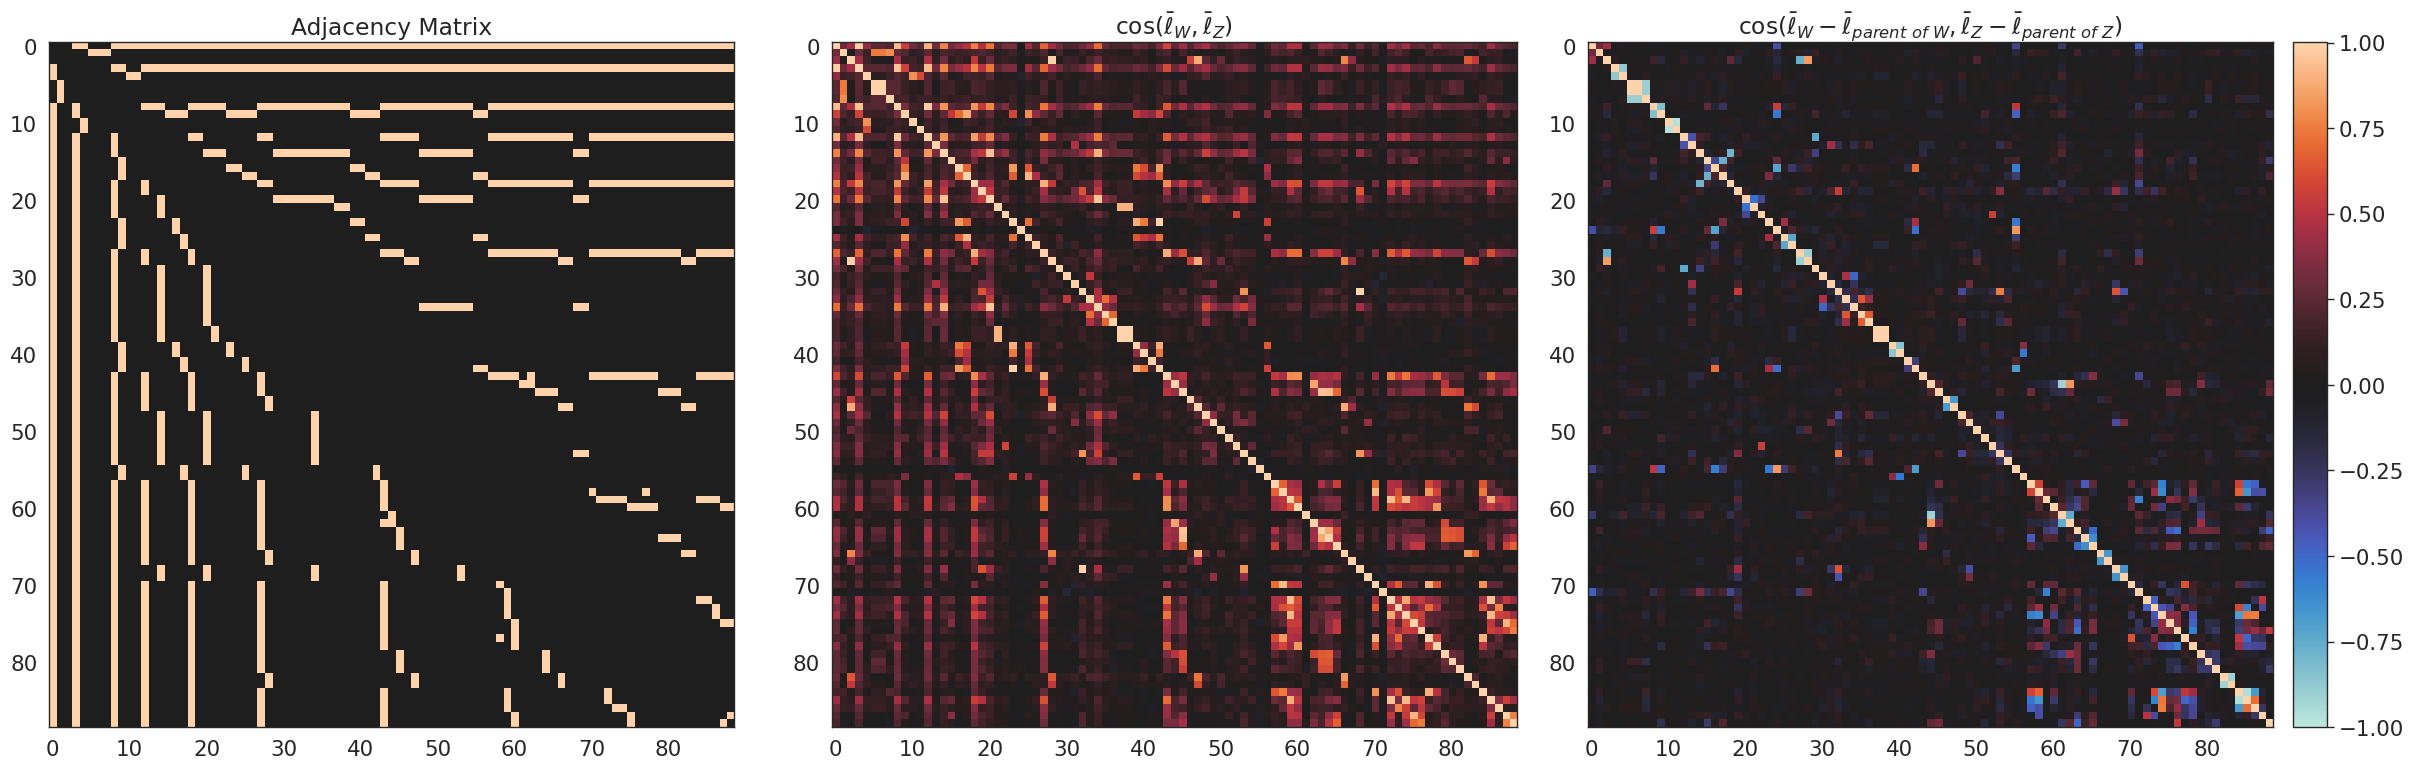

In [5]:
tc_G = nx.algorithms.dag.transitive_closure(G)
adj_mat = nx.adjacency_matrix(tc_G, nodelist=sorted_keys).todense()
adj_mat = adj_mat + adj_mat.T

lda_dirs = torch.stack([v['lda'] for k, v in dirs.items()])
lda_dirs = lda_dirs / lda_dirs.norm(dim = 1).unsqueeze(1)



child_parent = {}

print(sorted_keys)

for node in list(messed_up.keys()):
     sorted_keys.remove(node)
#      print(node)

class_counter = 0
for node in sorted_keys:
        if len(list(G.predecessors(node))) > 0:
                parent = list(G.predecessors(node))[0]         #direct parent
                # print("node: "+ node)
                # print("parent: "+ parent)
                # print()
                # print(list(G.predecessors(node)))
                if parent not in list(messed_up.keys()):
                        # print(dirs[node]['lda'])
                        if [*dirs[node]['lda']] == [*dirs[parent]['lda']]:
                               print(f"equal: {node}, {parent}")
                        child_parent.update({node:  dirs[node]['lda'] - dirs[parent]['lda']})
        else:
               class_counter += 1
               print("reject: " + node)         #throws out 3

# lda_diff = torch.stack([lda_dirs[0]] + [v for k, v in child_parent.items()])        #adds back 1: 100 - 3 + 1 = 98
lda_diff = torch.stack([lda_dirs[i] for i in range(class_counter)] + [v for k, v in child_parent.items()])



lda_diff = lda_diff / lda_diff.norm(dim = 1).unsqueeze(1)
# lda_diff = lda_diff / (lda_diff.norm(dim = 1)+0.001).unsqueeze(1)



# multiplying by transpose to get cosine similarity
# num_concepts x embedding_dim * embedding_dim x num_concepts = num_concepts x num_concepts
mats = [adj_mat,
        (lda_dirs @ lda_dirs.T).cpu().numpy(),
        (lda_diff @ lda_diff.T).cpu().numpy()]

titles = ["Adjacency Matrix",
          rf'$\cos(\bar{{\ell}}_{{W}}, \bar{{\ell}}_{{Z}})$',
          rf'$\cos(\bar{{\ell}}_{{W}} - \bar{{\ell}}_{{parent \,\, of \,\, W}}, \bar{{\ell}}_{{Z}} - \bar{{\ell}}_{{parent \,\, of \,\,Z}})$']
 
hrc.cos_heatmap(mats, titles, figsize = (25, 8),
                use_absvals=False,
                save_as = "noun_single_three_heatmap")

# print(mats[2][8])

In [6]:
for mat in mats:
    print(mat.shape)

(89, 89)
(89, 89)
(89, 89)


In [7]:
print(dirs)

{'entity': {'lda': tensor([-0.0880, -0.0194, -0.0387, -0.0869,  0.1386,  0.2338,  0.0162, -0.0733,
        -0.0467,  0.2100,  0.2008,  0.1019, -0.1086, -0.0299,  0.0941,  0.1965,
         0.0192,  0.1987,  0.0198, -0.0172, -0.0618,  0.0225, -0.1466, -0.0510,
         0.0530,  0.1153,  0.0887, -0.2139, -0.1516, -0.0213, -0.1878, -0.1570,
         0.2071,  0.0958, -0.0747,  0.0107, -0.1447,  0.2109, -0.1353, -0.2304,
        -0.0240,  0.0628, -0.0437,  0.1443,  0.3170,  0.0910, -0.1125,  0.1452,
         0.0120,  0.0102,  0.0900,  0.0053,  0.0424,  0.1452,  0.2198, -0.0812,
        -0.1835,  0.1224, -0.0262,  0.0733,  0.1257,  0.2960,  0.0362, -0.1210,
        -0.0044,  0.0010, -0.0044,  0.0343, -0.0798,  0.0437, -0.1026,  0.1790,
         0.0799, -0.0384, -0.2014, -0.0204, -0.0100,  0.0948,  0.2109,  0.1203,
        -0.0015, -0.0767, -0.0761,  0.0178,  0.1407, -0.1378, -0.0508, -0.0307,
        -0.1256, -0.2589,  0.1580,  0.0610,  0.2878, -0.0993,  0.2495,  0.0209,
        -0.0144,  0.1

In [8]:
from networkx.drawing.nx_agraph import graphviz_layout
start_node = 'animal.n.01'
sub_G =nx.bfs_tree(G, start_node)
sub_G =  nx.DiGraph(G.subgraph(sub_G.nodes()))

pos = graphviz_layout(sub_G, prog='dot')
labels = {node: node.split('.', 1)[0] for node in sub_G.nodes()}

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
nx.draw_networkx_nodes(sub_G, pos, node_size=500, node_color='lightblue', alpha=0.2)
nx.draw_networkx_edges(sub_G, pos, edge_color='gray', width=2)
nx.draw_networkx_labels(sub_G, pos, labels=labels)

plt.axis('off')
plt.savefig(f"figures/sub_graph_tree.pdf", bbox_inches='tight')
plt.show()

NetworkXError: The node animal.n.01 is not in the digraph.

In [ ]:
sub_sorted_keys = list(nx.topological_sort(sub_G))
tc_G = nx.algorithms.dag.transitive_closure(G.subgraph(sub_sorted_keys))
adj_mat = nx.adjacency_matrix(tc_G, nodelist = sub_sorted_keys).todense()
adj_mat = adj_mat + adj_mat.T

lda_dirs = torch.stack([dirs[node]['lda'] for node in sub_sorted_keys])
lda_dirs = lda_dirs / lda_dirs.norm(dim = 1).unsqueeze(1)

child_parent = {}

for node in sub_sorted_keys:
    if len(list(sub_G.predecessors(node))) > 0:
        parent = list(sub_G.predecessors(node))[0]
        child_parent.update({node: dirs[node]['lda'] - dirs[parent]['lda']})
    
lda_diff = torch.stack([lda_dirs[0]] + [v for k, v in child_parent.items()])
lda_diff = lda_diff / lda_diff.norm(dim = 1).unsqueeze(1)

mats = [adj_mat,
        (lda_dirs @ lda_dirs.T).cpu().numpy(),
        (lda_diff @ lda_diff.T).cpu().numpy()]

titles = ["Adjacency Matrix",
          rf'$\cos(\bar{{\ell}}_{{W}}, \bar{{\ell}}_{{Z}})$',
          rf'$\cos(\bar{{\ell}}_{{W}} - \bar{{\ell}}_{{parent \,\, of \,\, W}}, \bar{{\ell}}_{{Z}} - \bar{{\ell}}_{{parent \,\, of \,\,Z}})$']

hrc.cos_heatmap(mats, titles, figsize = (27, 8),
                labels = [node.split('.', 1)[0] for node in sub_sorted_keys],
                use_absvals=False,
                save_as = "sub_noun_single_three_heatmap")

: 